### Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

### Functions & Classes

In [2]:
#Returns counts of unique values of an attribute                
def count_unique_values(data):
    values, counts = np.unique(data, return_counts = True)
    return values, counts

#Interchange keys and values in a dictionary
def swap_dict(d):
    return {v: k for k, v in d.items()}

#Get context as a dictionary where they are grouped by categories
def texts_by_categories(X_train, y_train, categories):
    l = len(X_train)
    dic = dict()
    for category in categories:
        dic[category] = ""
    for i in range(l):
        if dic[y_train[i]] == "":
            dic[y_train[i]] += X_train[i]
        else:
            dic[y_train[i]] += " " + X_train[i]
    return dic

#Create probability table of the used words by using frequency array
def get_probability_table(freq_arr):
    table = np.zeros(freq_arr.shape)
    for i in range(len(freq_arr)):
        total = np.sum(freq_arr[i])
        for j in range(len(freq_arr[i])):
            p = np.log((freq_arr[i][j] + 1) / (total + 3)) #alpha * k where alpha = 1 and k = 3
            table[i][j] = p
    
    return table

#Returns unigram frequency array converted to probability table in dictionary version and vocabulary
def unigram_freq_arr(dict_context):
    #Unigram frequency array
    vectorizer = CountVectorizer()
    freq = vectorizer.fit_transform(list(dict_context.values()))
    vectorizer.get_feature_names_out()
    freq_arr = freq.toarray()
    vocabulary = vectorizer.vocabulary_
    #Probability table
    table = get_probability_table(freq_arr)
    d = dict()
    for i in range(len(list(dict_context))):
        d[list(dict_context)[i]] = table[i] 
    return d, vocabulary

#Returns bigram frequency array converted to probability table in dictionary version and vocabulary
def bigram_freq_arr(dict_context):
    #Bigram frequency array
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))
    freq = vectorizer.fit_transform(list(dict_context.values()))
    vectorizer.get_feature_names_out()
    freq_arr = freq.toarray()
    vocabulary = vectorizer.vocabulary_
    #Probability table
    table = get_probability_table(freq_arr)
    d = dict()
    for i in range(len(list(dict_context))):
        d[list(dict_context)[i]] = table[i] 
    return d, vocabulary

def unigram_naive_bayes_classification(X_test, probability_table_dict, vocabulary):
    #X_test frequency array and its vocabulary
    vectorizer = CountVectorizer()
    freq = vectorizer.fit_transform([X_test])
    vectorizer.get_feature_names_out()
    freq_arr = freq.toarray()
    X_test_vocabulary = vectorizer.vocabulary_
    index_to_word_dict = swap_dict(X_test_vocabulary)
    
    #Calculating probabilities for each category
    probability_as_key_dict = dict()
    for category in list(probability_table_dict.keys()):
        table = probability_table_dict[category]
        total = 0
        for i in range(len(freq_arr[0])):
            n = freq_arr[0][i] #Number of the word occured in the text
            word = index_to_word_dict[i]
            if word in vocabulary.keys():
                total += n * probability_table_dict[category][vocabulary[word]]
            else:
                total += n * np.log(1/(len(probability_table_dict[category]) + 3))
        probability_as_key_dict[total] = category
    
    #Determining the highest probability over all the categories
    max_val = max(list(probability_as_key_dict.keys()))
    category = probability_as_key_dict[max_val]
    
    return category

def bigram_naive_bayes_classification(X_test, probability_table_dict, vocabulary):
    #X_test frequency array and its vocabulary
    vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2))
    freq = vectorizer.fit_transform([X_test])
    vectorizer.get_feature_names_out()
    freq_arr = freq.toarray()
    X_test_vocabulary = vectorizer.vocabulary_
    index_to_word_dict = swap_dict(X_test_vocabulary)
    
    #Calculating probabilities for each category
    probability_as_key_dict = dict()
    for category in list(probability_table_dict.keys()):
        table = probability_table_dict[category]
        total = 0
        for i in range(len(freq_arr[0])):
            n = freq_arr[0][i] #Number of the word occured in the text
            word = index_to_word_dict[i]
            if word in vocabulary.keys():
                total += n * probability_table_dict[category][vocabulary[word]]
            else:
                total += n * np.log(1/(len(probability_table_dict[category]) + 3))
        probability_as_key_dict[total] = category
    
    #Determining the highest probability over all the categories
    max_val = max(list(probability_as_key_dict.keys()))
    category = probability_as_key_dict[max_val]
    
    return category

class naive_bayes_classifier:
    
    def __init__(self, X_train, X_test, y_train, y_test, type_BoW):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.type_BoW = type_BoW
        self.y = np.append(y_train, y_test)
        self.categories, self._ =  count_unique_values(self.y)
        self.context_dic = texts_by_categories(self.X_train, self.y_train, self.categories)
        self.confusion_matrix = np.zeros(shape = (len(self.categories), len(self.categories)), dtype=int)
        
    def classify(self):
        
        cat_2_ind = dict()
        for i in range(len(self.categories)):
            cat_2_ind[self.categories[i]] = i
        
        if (self.type_BoW == "unigram"):
            d, v = unigram_freq_arr(self.context_dic)
            for i in range(len(self.X_test)):
                test_rec = self.X_test[i]
                actual = self.y_test[i]
                classified = unigram_naive_bayes_classification(test_rec, d, v)
                self.confusion_matrix[cat_2_ind[classified]][cat_2_ind[actual]] += 1
                
        if (self.type_BoW == "bigram"):
            d, v = bigram_freq_arr(self.context_dic)
            for i in range(len(self.X_test)):
                test_rec = self.X_test[i]
                actual = self.y_test[i]
                classified = bigram_naive_bayes_classification(test_rec, d, v)
                self.confusion_matrix[cat_2_ind[classified]][cat_2_ind[actual]] += 1
                
    def get_accuracy(self):
        return np.trace(self.confusion_matrix) / np.sum(self.confusion_matrix) * 100
    
    def plot(self):
        df_cm = pd.DataFrame(self.confusion_matrix, index = [i for i in self.categories], columns = [i for i in self.categories])
        plt.figure(figsize = (7,7))
        ax = sn.heatmap(df_cm, annot=True, fmt = "d", cmap="YlGnBu", cbar_kws={'label': 'Scale'})
        ax.set(ylabel="Predicted Label", xlabel="Actual Label")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.title("Confusion Matrix")

### Parameter for the data

In [3]:
csvFile = 'English Dataset.csv'
targetColumn = 'Category'
textColumn = 'Text'

### Preparing data for the classifier

In [4]:
#Reading .csv file
df = pd.read_csv(csvFile)
#Splitting train and test dataset and shuffling
X = df[textColumn].to_numpy()
y = df[targetColumn].to_numpy()
# 70% train set, 30% test set splitted.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y
                                                    ,random_state=52
                                                    ,train_size=0.7
                                                    ,shuffle=True)

### Unigram vs. Bigram Classifying Performance

Unigram Method Accuracy: %97.99


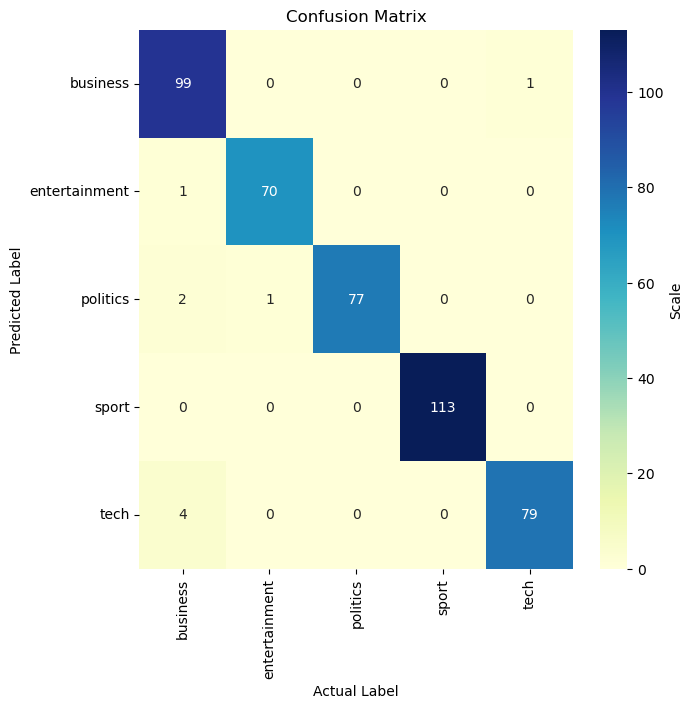

In [8]:
classifier = naive_bayes_classifier(X_train, X_test, y_train, y_test, "unigram")
classifier.classify()
classifier.plot()
print("Unigram Method Accuracy: %{:.2f}".format(classifier.get_accuracy()))

Bigram Method Accuracy: %97.32


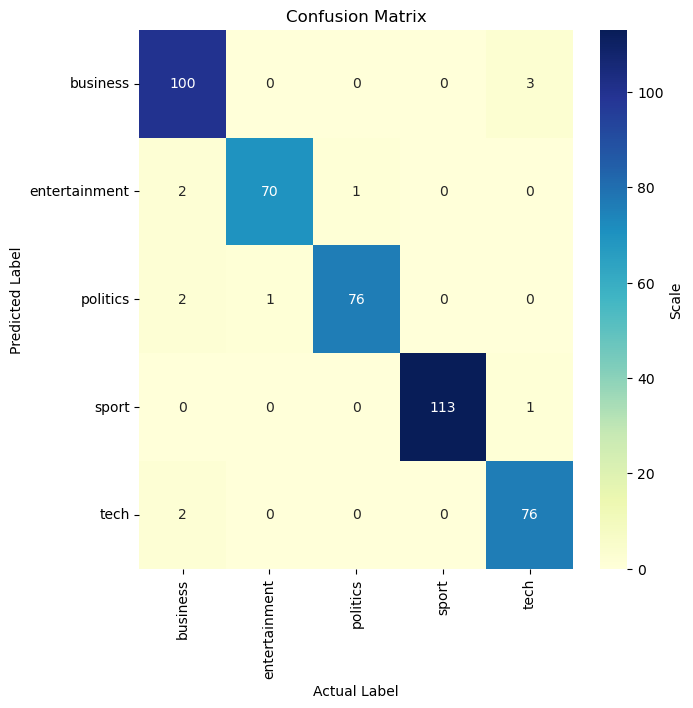

In [9]:
classifier2 = naive_bayes_classifier(X_train, X_test, y_train, y_test, "bigram")
classifier2.classify()
classifier2.plot()
print("Bigram Method Accuracy: %{:.2f}".format(classifier2.get_accuracy()))